In [1]:
# Imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

from mltools import classification_tools as CT
from mltools import model_tools as MT

# EDA

In [2]:
# Import dataset
df = pd.read_csv('Diabetes.csv', sep=';')
df.head()

,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Missing values
df.info()
# No missing values

In [ ]:
# Plot data and outliers
df.describe()

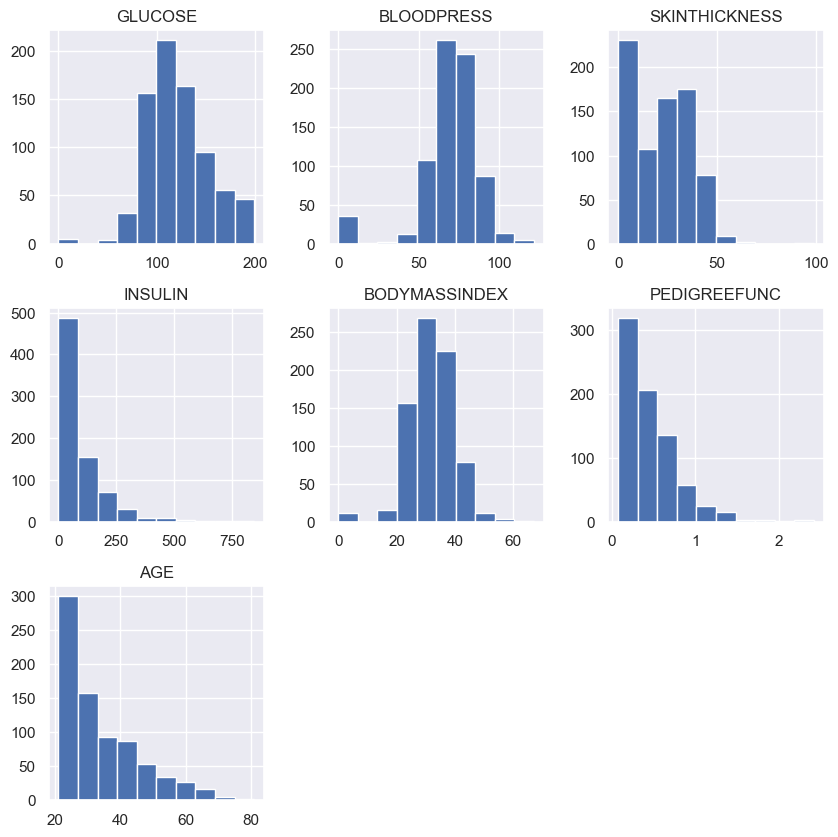

In [3]:
# Continious variables plot. Most of them are skewed. Bodymassindex may be normal (with more data we would be more confident)
df.drop(['PREGNANT', 'DIABETES'], axis=1).hist(figsize=(10,10))
plt.show()

In [4]:
# It can be observed some variables taking 0 value when it is no reasonable. Remove them.
df = df.loc[(df.GLUCOSE > 0) & (df.BLOODPRESS > 0) & (df.BODYMASSINDEX > 0) & (df.INSULIN > 0), :]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 3 to 765
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PREGNANT       392 non-null    int64  
 1   GLUCOSE        392 non-null    int64  
 2   BLOODPRESS     392 non-null    int64  
 3   SKINTHICKNESS  392 non-null    int64  
 4   INSULIN        392 non-null    int64  
 5   BODYMASSINDEX  392 non-null    float64
 6   PEDIGREEFUNC   392 non-null    float64
 7   AGE            392 non-null    int64  
 8   DIABETES       392 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 30.6 KB


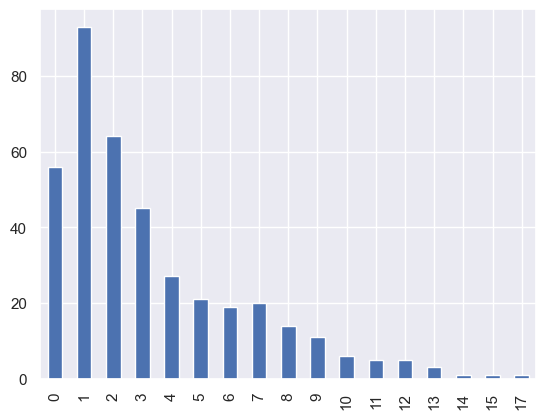

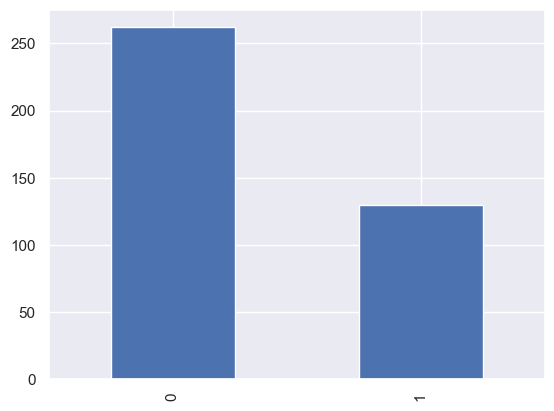

In [5]:
# Discrete variables plot. Pregnant variable is skewed. We can see an unbalance in the diabetes variable.
df['PREGNANT'].value_counts().sort_index().plot.bar()
plt.show()
df['DIABETES'].value_counts().sort_index().plot.bar()
plt.show()

In [ ]:
df.plot.box(subplots=True, layout=(3, 3), sharex=False, sharey=False, figsize=(10,10))
plt.show()
# Outliers can be observed (not all of them, this is just a proyection in 1 dimension)

In [6]:
# Encode categorical values
df.DIABETES = df.DIABETES.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 3 to 765
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PREGNANT       392 non-null    int64   
 1   GLUCOSE        392 non-null    int64   
 2   BLOODPRESS     392 non-null    int64   
 3   SKINTHICKNESS  392 non-null    int64   
 4   INSULIN        392 non-null    int64   
 5   BODYMASSINDEX  392 non-null    float64 
 6   PEDIGREEFUNC   392 non-null    float64 
 7   AGE            392 non-null    int64   
 8   DIABETES       392 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 28.1 KB


In [ ]:
# Analyze continious variables

# Pairplot 
sns.pairplot(df, hue = 'DIABETES')
plt.show()
sns.pairplot(df)
plt.show()
# It can be observed some skewed variables, they can be normalized.

In [7]:
# Data engenieering from the pairplot
# Glucose around 100 in one of the categories
df['DISG'] = (df['GLUCOSE'] - 100) ** 2

In [ ]:
# Correlation plot
#correlation plot of numeric variables
f = plt.figure(figsize=(15,15))
plt.matshow(df.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()
# By looking at the plot, there are no many variables correlated. The ones witch are more correlated are Age, pregnant and DisG, glucose (DisG calculated using glucose)

In [8]:
# Class imbalance
print(df['DIABETES'].value_counts())
# As we can see, class number 0 has double of rows than class number 1 (down-sampling or up-sampling could be used)

# Down-sampling
dw = resample(df.loc[df.DIABETES == 0, :], replace=True, n_samples=400, random_state=2022)

# Up-sampling
up = resample(df.loc[df.DIABETES == 1, :], replace=True, n_samples=400, random_state=2022)

# Balanced dataset
df = pd.concat([dw, up])

df.DIABETES.value_counts()

0    262
1    130
Name: DIABETES, dtype: int64


0    400
1    400
Name: DIABETES, dtype: int64

In [9]:
# Train test split

# Define input and output matrices
INPUTS = list(df.columns)
OUTPUT = 'DIABETES'
INPUTS.remove(OUTPUT)
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)  

In [11]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test

 # Logistic Regression

In [ ]:
## plot training and test sets. 
# Plot glucose over age. They follow the same distribution in train and test. 

# Train plot
palette = {0:'C0', 1:'C1'} # Color palette 
sns.scatterplot(x = 'GLUCOSE', y = 'AGE', hue = 'Y', data = dfTR_eval, palette=palette).set_title("Training set")
plt.show()

# Test plot
plt.figure()
sns.scatterplot(x = 'GLUCOSE', y = 'AGE', hue = 'Y', data = dfTS_eval, palette=palette).set_title("Test set")
plt.show()

In [ ]:
# Input setting

# Remove this varivable from the numeric input (they will be polynomial)
NEW_INPUTS = INPUTS.copy()
NEW_INPUTS.remove('AGE')
NEW_INPUTS.remove('GLUCOSE')

# Set diferent types of inputs
INPUTS_LR_NUM =  NEW_INPUTS
INPUTS_LR_SQ = ['AGE', 'GLUCOSE']
INPUTS_LR_CAT = []
INPUTS_LR = INPUTS_LR_NUM + INPUTS_LR_SQ + INPUTS_LR_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the quadratic variables by scaling and transforming into a 2 degree polynomial
square_transformer = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('Poly',PolynomialFeatures())])

# Prepare the categorical variables by encoding the categories (No categorical variables)
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_LR_NUM),
        ('sq', square_transformer, INPUTS_LR_SQ),
        ('cat', categorical_transformer, INPUTS_LR_CAT)
        ])

# Create model
LogReg_fit = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
                        ('LogReg',LogisticRegression(random_state=2022))]) # Model to use in the pipeline
#Train model
LogReg_fit.fit(X_train[INPUTS_LR], y_train)

print("Logistic Regression Trained")

In [ ]:
# Obtain Cross-Validation accuracy
print("CV accuracy is")
print(cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring='accuracy').mean())

In [ ]:
# Regression summary
CT.summaryLogReg(LogReg_fit, X_train[INPUTS_LR], y_train)
# We can see the estimated values for the variables defined. We can see another measures asociated with them.
# PEDIGREEFUNC, BODYMASSINDEX, DISG, AGE, GLUCOSE and AGE**2 are the most significant variables.  

In [ ]:
# Obtain a report of the model based on predictions 
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,0]
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,1]
# Scale test using preprocess in training
dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,1]

#visualize evaluated data
print(dfTR_eval.head())
print(dfTS_eval.head())

In [ ]:
# Plot classification in a 2 dimensional space (Glucose x Age)
plt.figure(figsize=(10, 5))
CT.plot2DClass(X_train[INPUTS_LR], dfTR_eval['Y'], LogReg_fit, 'GLUCOSE', 'AGE', 'YES', 50) 

In [ ]:
# Confusion matrix for Log Reg Model
# As a false negative is the worst scenario, we are interested in that measure
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LR_pred'])
# Accuracy = 0.3 better than the NIR model
# Kappa = 0.59, closer to 1 than 0 (value expected by chance)
# Mcnemar's Test P-Value = 0.94, do not reject null hypotesis that model predicted values are different from real values
# Sensitivity = 0.81, percentage of true values correctly predicted from the real true values
# Specificity = 0.78, percentage of false values correctly predicted from the real false values
# Pos pred value = 0.79, percentage of positives values correctly predicted from the predeicted true values
# Neg pred value = 0.80, percentage of negative values correctly predicted from the predeicted negative values (value we are interested in)
# Detection rate = 0.4, as there are half of each class, best situation is 0.5 and worst 0.
# Prevalence = 0.5 as expected (half of the examples were positive)
# Prevalence close to detection prevalence (total number of true values close to number of true clasifications)
# Balanced accuracy = accuracy (already balanced)
# F Score cercano a 1, mejor valor esperado

In [ ]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LR_pred'])

# Values obtained for the test similar to training -> Good generalization

In [ ]:
CT.plotClassPerformance(dfTR_eval['Y'], LogReg_fit.predict_proba(X_train[INPUTS_LR]), selClass=1)

# Calibration plot: when we assing probabilities close to 0.5, there are more real positive values (around 0.6), they should be close to 0.5 each class
# Histograms: Probabilities are condensed on the outsides, but we would like to see a more defined tendency 
# AUC: equals to 0.876, close to 1, that means our model performs well with different thresholds
# Accuracy across posible cutoffs plot shows that when the thresholds is close to 0.5 it performs the best

# KNN

In [ ]:
# KNN MODEL

# Inputs of the model.
INPUTS_KNN = INPUTS.copy()

# Configure model and hyparameter tuning.
param = {'knn__n_neighbors': range(3,135,4)}

# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined. 
nFolds = 10
knn_fit = GridSearchCV(estimator=pipe, # Model to use
                        param_grid=param, # Grid to search in
                        n_jobs=-1, # Number of cores to use
                        scoring='accuracy', # Accuracy 
                        cv=nFolds) # Number of Folds 

# Search in grid and train model
knn_fit.fit(X_train[INPUTS_KNN], y_train) 

print("KNN Trained")

In [ ]:
# Scoring plot for each number of neighbors.
# Best model obtained with 7 neighbors (complex model). Greater number of neighbors will lead to a more robust model but a decrease in the score.
MT.plotModelGridError(knn_fit)

In [ ]:
# Report of the model based on predictions
dfTR_eval['Y_knn_pred'] = knn_fit.predict(X_train[INPUTS_KNN])
dfTR_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,0]
dfTR_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,1]
# Scale test using preprocess in training
dfTS_eval['Y_knn_pred'] = knn_fit.predict(X_test[INPUTS_KNN])
dfTS_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,0]
dfTS_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,1]

In [ ]:
# Plot classification in a 2 dimensional space
plt.figure(figsize=(10, 5))
CT.plot2DClass(X_train[INPUTS_KNN], dfTR_eval['Y'], knn_fit, 'GLUCOSE', 'AGE', 'YES', 50) 

In [ ]:
# Confucion matrix for training set
# Again, as a false negative is the worst scenario, we are interested in that measure
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_knn_pred'])
# Accuracy 0.34 superior to the NIR model
# Kappa = 0.68, closer to 1 than 0 (value expected by chance)
# Sensitivity = 0.86, percentage of true values correctly predicted from the real true values
# Specificity = 0.82, percentage of false values correctly predicted from the real false values
# Pos pred value = 0.83, percentage of positives values correctly predicted from the predeicted true values
# Neg pred value = 0.85, percentage of negative values correctly predicted from the predeicted negative values (value we are interested in)
# Prevalence = 0.5 as expected (half of the examples were positive)
# Prevalence close to detection prevalence (total number of true values close to number of true clasifications)
# Detection rate = 0.43, as there are half of each class, best situation is 0.5 and worst 0.
# Balanced accuracy = accuracy (already balanced)
# F score cercano a 1, mejor valor esperado

In [ ]:
# Confucion matrix for test set
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_knn_pred'])
# All values decreased compared to wtraining set -> Generalitation not as good as LR model 

In [ ]:
CT.plotClassPerformance(dfTR_eval['Y'], knn_fit.predict_proba(X_train[INPUTS_KNN]), selClass=1)

# Calibration plot: probabilities assigned are close to the true probability for its value
# Histograms: Probabilities are condensed on the outsides, but we would like to see a more defined tendency 
# AUC: equals to 0.921, close to 1, that means our model performs well with different thresholds
# Accuracy across posible cutoffs plot shows that when the thresholds is close to 0.45 it performs the best. From the value obtained for 0, it can be deduced
# there is a big number of data points with 0 probability.

# SVM

In [12]:
# Radial SVM MODEL

## Inputs of the model. Change accordingly to perform variable selection
INPUTS_RSVC = INPUTS.copy()
## Train model
param = {'SVC__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000], # Cost term
         'SVC__gamma':[0.0001,0.001,0.01,0.1,1,10]} # Inverse width parameter in the Gaussian Radial Basis kernel 
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('SVC', SVC(kernel='rbf', # gaussian kernel
                                   probability=True, # let the model predict probabilities
                                   random_state=150))]) # For replication

# Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
SVC_fit = GridSearchCV(estimator=pipe, # Structure of the model
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use
                       scoring='accuracy', # Accuracy
                       cv=nFolds) # Number of Folds 
SVC_fit.fit(X_train[INPUTS_RSVC], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVC',
                                        SVC(probability=True,
                                            random_state=150))]),
             n_jobs=-1,
             param_grid={'SVC__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                    1000],
                         'SVC__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring='accuracy')

In [13]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(SVC_fit, X_train[INPUTS_RSVC], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.9484375

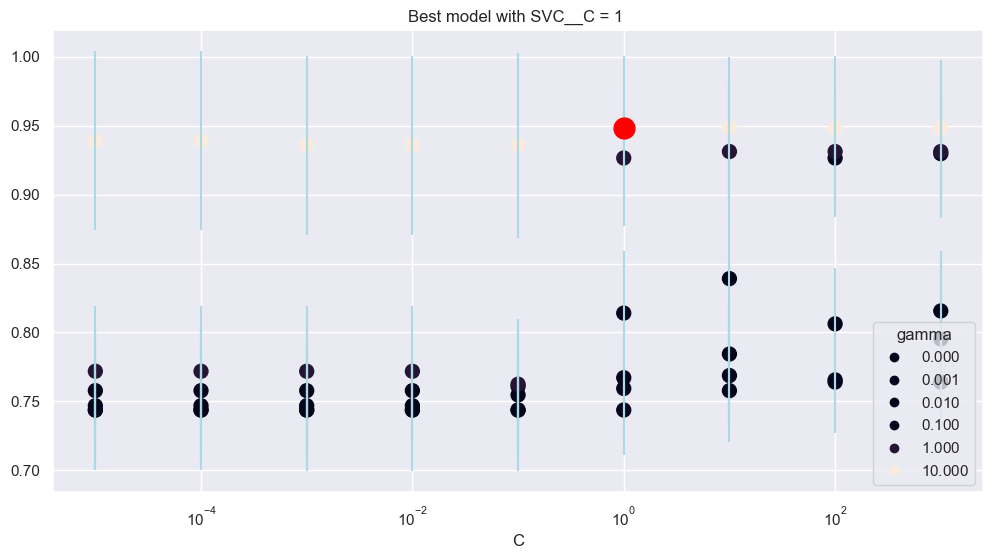

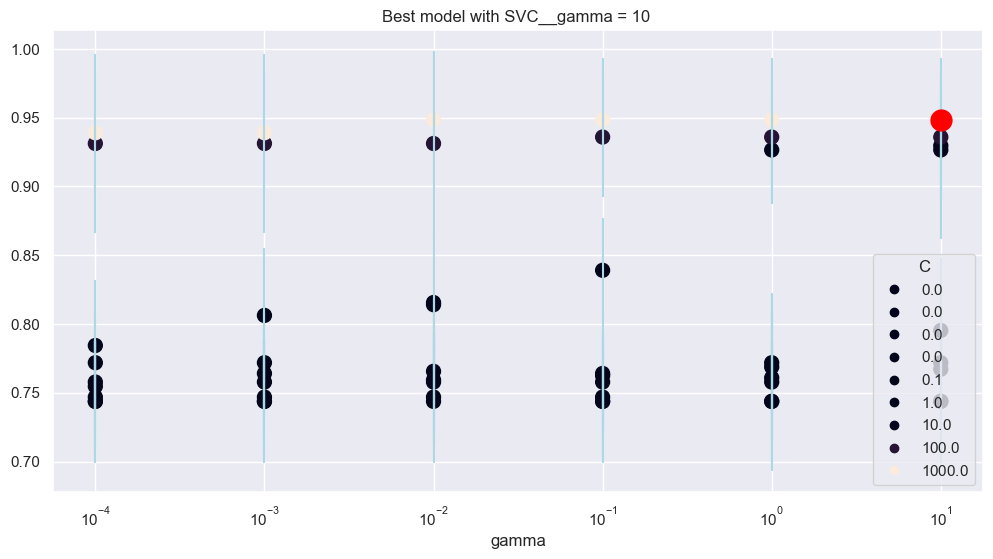

In [14]:
MT.plotModelGridError(SVC_fit, xscale="log", xscale2='log')
# Best model with cost = 1 and gamma = 10

In [15]:
# Report of the model based on predictions
dfTR_eval['Y_SVC_pred'] = SVC_fit.predict(X_train[INPUTS_RSVC])
dfTR_eval['Y_SVC_prob_neg'] = SVC_fit.predict_proba(X_train[INPUTS_RSVC])[:,0]
dfTR_eval['Y_SVC_prob_pos'] = SVC_fit.predict_proba(X_train[INPUTS_RSVC])[:,1]
#Scale test using preprocess in training
dfTS_eval['Y_SVC_pred'] = SVC_fit.predict(X_test[INPUTS_RSVC])
dfTS_eval['Y_SVC_prob_neg'] = SVC_fit.predict_proba(X_test[INPUTS_RSVC])[:,0]
dfTS_eval['Y_SVC_prob_pos'] = SVC_fit.predict_proba(X_test[INPUTS_RSVC])[:,1]

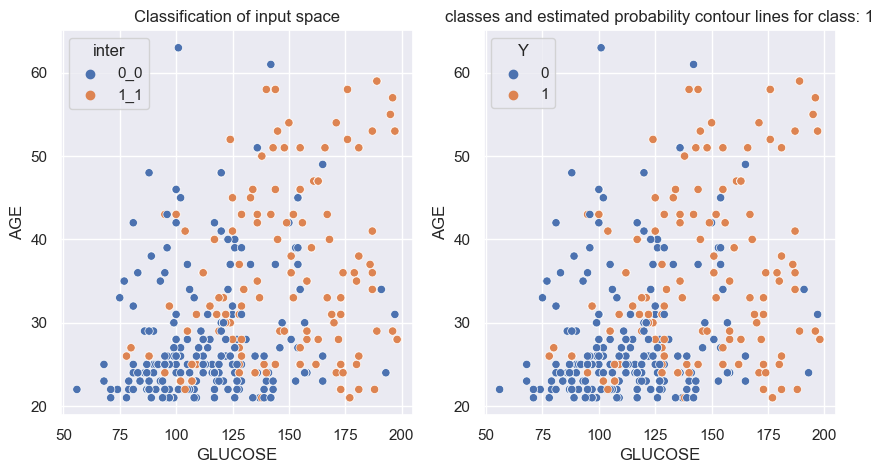

In [16]:
# Plot classification in a 2 dimensional space
plt.figure(figsize=(10, 5))
CT.plot2DClass(X_train[INPUTS_RSVC], dfTR_eval['Y'], SVC_fit, 'GLUCOSE', 'AGE', 1, 50) 

In [17]:
# Train confusion matrix
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_SVC_pred'])
# Accuracy 0.34 superior to the NIR model
# Kappa = 0.68, closer to 1 than 0 (value expected by chance)
# Sensitivity = 0.86, percentage of true values correctly predicted from the real true values
# Specificity = 0.82, percentage of false values correctly predicted from the real false values
# Pos pred value = 0.83, percentage of positives values correctly predicted from the predeicted true values
# Neg pred value = 0.85, percentage of negative values correctly predicted from the predeicted negative values (value we are interested in)
# Prevalence = 0.5 as expected (half of the examples were positive)
# Prevalence close to detection prevalence (total number of true values close to number of true clasifications)
# Detection rate = 0.43, as there are half of each class, best situation is 0.5 and worst 0.
# Balanced accuracy = accuracy (already balanced)
# F score cercano a 1, mejor valor esperado

Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 320   0
         1   0 320

Accuracy: 1.0
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Pos pred value: 1.0
Neg pred value: 1.0
Prevalence: 0.5
Detection Rate: 0.5
Detection prevalence: 0.5
Balanced accuracy: 1.0
F Score: 1.0
Positive class: 1


In [18]:
# Test confusion matrix
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_SVC_pred'])
# Accuracy 0.34 superior to the NIR model
# Kappa = 0.68, closer to 1 than 0 (value expected by chance)
# Sensitivity = 0.86, percentage of true values correctly predicted from the real true values
# Specificity = 0.82, percentage of false values correctly predicted from the real false values
# Pos pred value = 0.83, percentage of positives values correctly predicted from the predeicted true values
# Neg pred value = 0.85, percentage of negative values correctly predicted from the predeicted negative values (value we are interested in)
# Prevalence = 0.5 as expected (half of the examples were positive)
# Prevalence close to detection prevalence (total number of true values close to number of true clasifications)
# Detection rate = 0.43, as there are half of each class, best situation is 0.5 and worst 0.
# Balanced accuracy = accuracy (already balanced)
# F score cercano a 1, mejor valor esperado

Confusion Matrix and Statistics
	   Prediction
 Reference  0  1
         0 80  0
         1  5 75

Accuracy: 0.97
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.94
Mcnemar's Test P-Value: 0.06
Sensitivity: 0.94
Specificity: 1.0
Pos pred value: 1.0
Neg pred value: 0.94
Prevalence: 0.5
Detection Rate: 0.47
Detection prevalence: 0.47
Balanced accuracy: 0.97
F Score: 0.97
Positive class: 1


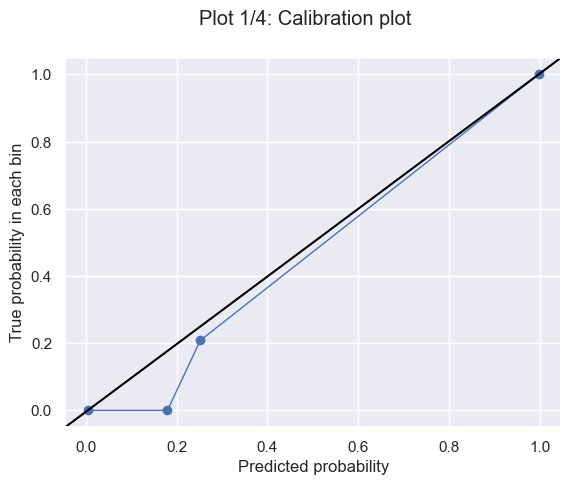

c:\Users\revue\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\revue\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


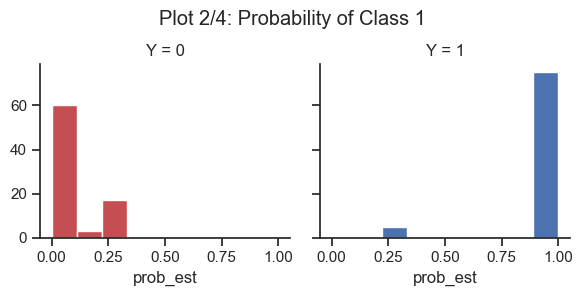

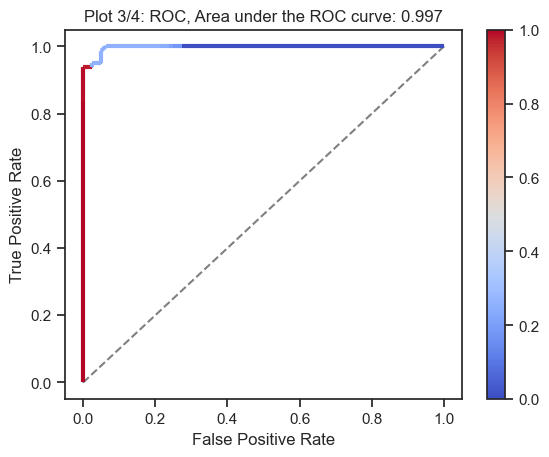

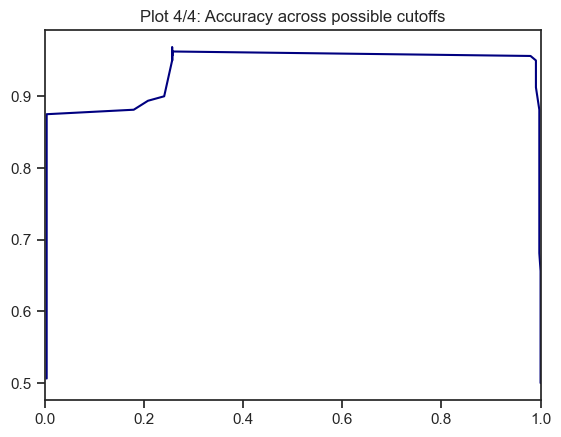

In [19]:
CT.plotClassPerformance(dfTS_eval['Y'], SVC_fit.predict_proba(X_test[INPUTS_RSVC]), selClass=1)

# Compare Models

In [ ]:
# Compare models
metric = 'Accuracy'
score = {'Decision Tree': cross_val_score(tree_fit, X_train[INPUTS_DT], y_train, cv=10, scoring='accuracy'), 
         'Random Forest': cross_val_score(rf_fit, X_train[INPUTS_RF], y_train, cv=10, scoring='accuracy') }
MT.dotplot(score, metric)

In [ ]:
CT.calibration_plot(y_test, dfTS_eval[['Y_DT_prob_pos','Y_RF_prob_pos']])
CT.roc_curve(y_test,dfTS_eval[['Y_DT_prob_pos','Y_RF_prob_pos']], 'YES')